In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import seaborn as sns

from pathlib import Path
from MITRotor import IEA10MW

In [2]:
rotor = IEA10MW()

nElements = 26
nSections = 158

In [3]:
def extract_columns(file_list):
    data_dict = {}
    
    for file in file_list:
        with open(file, 'r') as f:
            lines = f.readlines()
            
            # Skip the header line and extract columns 1, 4, and 5
            data = np.loadtxt(lines[1:])[:, [0, 3, 4]]
            
            # Use the filename without the path and extension as the dictionary key
            key = Path(file).parent.name
            data_dict[key] = data
    
    return data_dict

In [4]:
wrfles_bem = []
# wrfles_wind = []
wrfles_bem.append(dict(np.load('/scratch/09909/smata/wrf_les_sweep/runs/10MW/rate/uniform_test/new_testing/base/points_15/case_4/U07_lite.npz')))

In [5]:
file_list = glob.glob("/scratch/09909/smata/wrf_les_sweep/runs/10MW/rate/uniform_test/new_testing/base/points_15/case_4/input_sounding")

data = extract_columns(file_list)

t = np.linspace(0,2*np.pi,nSections)
r = np.linspace(0,1,nElements)

R, T = np.meshgrid(r, t)

X = R * np.sin(T)
Y = (R * np.cos(T)) * wrfles_bem[0]['diameter']/2 + 378

In [6]:
fontsize = 24
plt.rcParams['xtick.labelsize'] = 20 
plt.rcParams['ytick.labelsize'] = 20 

plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

In [7]:
data

{'case_4': array([[  0.,   7.,   0.],
        [  1.,   7.,   0.],
        [  2.,   7.,   0.],
        ...,
        [829.,   7.,   0.],
        [830.,   7.,   0.],
        [831.,   7.,   0.]], shape=(832, 3))}

/tmp/ipykernel_719783/4269135001.py:102: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(ind_rotor[count], ct_rotor[count], cmap='viridis', s=110, edgecolor='none',color=colors[count],alpha=0.5,label = leg_strs[count], zorder = count + 2)


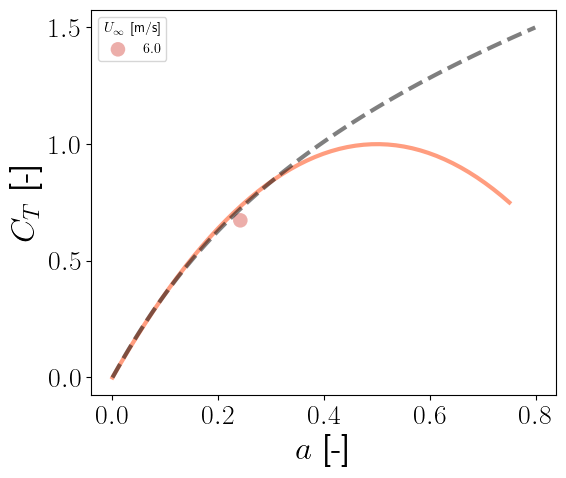

In [11]:
xs = [0,1,1,1,2,3,3,3,3,3,4,5,5,5,6]
ys = [2,1,2,3,2,0,1,2,3,4,2,1,2,3,2]

leg_strs = ['$6.0$','$7.0$','$8.0$', '$9.0$', '$10.0$']

ind_rotor = np.zeros_like(xs, dtype=float)
ct_rotor  = np.zeros_like(xs, dtype=float)

ind_loc = np.zeros((nElements, nSections, len(xs)))
ct_loc  = np.zeros((nElements, nSections, len(xs)))

colors = sns.color_palette("hls", 5)

fig, ax = plt.subplots(figsize=(6, 5))

casenames = ['case_4']

for count,case in enumerate(casenames):
    u_func = interp1d(data[case][:,0], data[case][:,1], kind='linear')
    v_func = interp1d(data[case][:,0], data[case][:,2], kind='linear')

    u_inf = u_func(Y)
    v_inf = v_func(Y)

    # Get radial points
    # a = ((wrfles_bem[count]['rOverR'] * rotor.R) - rotor.hub_radius)/rotor.R
    # r = (rotor.hub_radius + a * (rotor.R - rotor.hub_radius)) / rotor.R

    r = wrfles_bem[count]['rOverR'] * rotor.R

    # Compute induction
    ind = 1 - np.mean(wrfles_bem[count]['shapiroM'][0] * wrfles_bem[count]['u'],axis=0) / u_inf.T
    # ind = 1 - np.mean(wrfles_bem[count]['u'],axis=0) / u_inf.T


    phi = np.deg2rad(np.mean(wrfles_bem[count]['phi'], axis=0))
    Cl = np.mean(wrfles_bem[count]['cl'], axis=0)
    Cd = np.mean(wrfles_bem[count]['cd'], axis=0)

    r =  (np.ones_like(Cd.T) * r).T

    # Solidity
    # sigma = rotor.solidity_func(r)

#     chord = [
# 4.66770,
# 4.94644,
# 5.22519,
# 5.50393,
# 5.78268,
# 5.95490,
# 5.91736,
# 5.61917,
# 5.32097,
# 5.02278,
# 4.72458,
# 4.42639,
# 4.12819,
# 3.81434,
# 3.49131,
# 3.18302,
# 2.91082,
# 2.63862,
# 2.34715,
# 2.04702,
# 1.74690,
# 1.44677,
# 1.14664,
# 0.84651,
# 0.54639,
# 0.24626,
#     ]

    chord = rotor.chord_func(wrfles_bem[count]['rOverR'])

    chord =  (np.ones_like(Cd.T) * chord).T

    sigma2 = rotor.solidity_func(wrfles_bem[count]['rOverR'])
    sigma2 =  (np.ones_like(Cd.T) * sigma2).T

    sigma = (3 * chord) / (2 * np.pi * r)

    # Relative velocity
    W = np.mean(wrfles_bem[count]['vrel'], axis=0) / 7

    # Axial coefficient
    Cax = Cl * np.cos(phi) + Cd * np.sin(phi)

    # Local CT
    # ct = sigma * W**2 * Cax * wrfles_bem[count]['shapiroM'][0]**2
    ct = sigma * W**2 * Cax

    ind_loc[:,:,count] = ind
    ct_loc[:,:,count]  = ct

    ct_annular  = 1/(2 * np.pi) * np.trapezoid(ct, np.linspace(0, 2*np.pi, nSections), axis=-1)
    ind_annular = 1/(2 * np.pi) * np.trapezoid(ind, np.linspace(0, 2*np.pi, nSections), axis=-1)

    ct_rotor[count]  = 2 * np.trapezoid(ct_annular * wrfles_bem[count]['rOverR'], wrfles_bem[count]['rOverR'])
    ind_rotor[count] = 2 * np.trapezoid(ind_annular * wrfles_bem[count]['rOverR'], wrfles_bem[count]['rOverR'])

    ax.scatter(ind_rotor[count], ct_rotor[count], cmap='viridis', s=110, edgecolor='none',color=colors[count],alpha=0.5,label = leg_strs[count], zorder = count + 2)

a_mom = np.linspace(0,0.75,50)
ct_mom = 4 * a_mom * (1 - a_mom)
ax.plot(a_mom, ct_mom, '#ff3c00',linewidth=3,alpha = 0.5, zorder = 1)

ct_mad = np.linspace(0,1.5,75)
k1 = 0.2460
k2 = 0.0586
k3 = 0.0883
a_mad = k3 * ct_mad**3 + k2 * ct_mad**2 + k1 * ct_mad
ax.plot(a_mad, ct_mad, 'k--',linewidth=3,alpha=0.5,zorder=2)

ax.set_xlabel('$a$ [-]', fontsize=fontsize)
ax.set_ylabel('$C_T$ [-]', fontsize=fontsize)

plt.legend(title='$U_{\infty}$ [m/s]')

# ax[0,0].axis('off')
# ax[0,1].axis('off')
# ax[0,3].axis('off')


# plt.savefig(f"./figs/wrf_10MW_rotor.png", bbox_inches="tight", dpi=600)
plt.show()

In [13]:
[ind_rotor[0], ct_rotor[0]]

[np.float64(0.23185408150849574), np.float64(0.6730635591260987)]

In [37]:
ct_rotor

array([0.67306356, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [29]:
ind_rotor

array([0.21929737, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [27]:
wrfles_bem[count]['shapiroM'][0]**2

array([0.97591877], dtype=float32)

In [18]:
wrfles_bem[count]['u']

array([[[6.060541 , 6.0631466, 6.065648 , ..., 6.052157 , 6.0550385,
         6.057836 ],
        [5.9844985, 5.9864507, 5.9885454, ..., 5.979339 , 5.9809594,
         5.982674 ],
        [5.4406223, 5.438729 , 5.438992 , ..., 5.458459 , 5.4505706,
         5.4445963],
        ...,
        [4.0875   , 4.091281 , 3.964323 , ..., 3.979472 , 3.9622376,
         4.0899754],
        [4.4130154, 4.4253416, 4.4540253, ..., 4.482146 , 4.450758 ,
         4.4235926],
        [5.0617924, 5.061225 , 5.0576496, ..., 5.046775 , 5.0541296,
         5.0593977]],

       [[6.0602846, 6.062889 , 6.065389 , ..., 6.0519037, 6.054783 ,
         6.05758  ],
        [5.984113 , 5.9860635, 5.9881573, ..., 5.978961 , 5.9805775,
         5.982291 ],
        [5.4405007, 5.4385977, 5.4388533, ..., 5.458362 , 5.450465 ,
         5.444484 ],
        ...,
        [4.087411 , 4.091256 , 3.9644277, ..., 3.9794831, 3.962278 ,
         4.0898952],
        [4.41282  , 4.425227 , 4.45391  , ..., 4.4819593, 4.45065  ,
   

In [22]:
Cax

array([[0.55311567, 0.550087  , 0.5503691 , ..., 0.5528241 , 0.5529115 ,
        0.5530088 ],
       [0.47741258, 0.47411898, 0.4745157 , ..., 0.47729778, 0.47731954,
        0.4773571 ],
       [1.2861124 , 1.2866423 , 1.2866321 , ..., 1.2859057 , 1.2859784 ,
        1.2860479 ],
       ...,
       [1.3096434 , 1.2974792 , 1.298606  , ..., 1.2996897 , 1.2984245 ,
        1.2973996 ],
       [1.191884  , 1.1927899 , 1.1948885 , ..., 1.1969832 , 1.194574  ,
        1.192642  ],
       [1.1693043 , 1.1692417 , 1.1688918 , ..., 1.1678233 , 1.1685575 ,
        1.1690876 ]], shape=(26, 158), dtype=float32)

In [6]:
wrfles_bem[1]['shapiroM']

array([[0.98582274],
       [0.98582274],
       [0.98582274],
       [0.98582274],
       [0.98582274],
       [0.98582274],
       [0.98582274],
       [0.98582274],
       [0.98582274],
       [0.98582274],
       [0.98582274],
       [0.98582274],
       [0.98582274],
       [0.98582274],
       [0.98582274],
       [0.98582274],
       [0.98582274],
       [0.98582274],
       [0.98582274],
       [0.98582274],
       [0.98582274],
       [0.98582274],
       [0.98582274],
       [0.98582274],
       [0.98582274],
       [0.98582274],
       [0.98582274],
       [0.98582274],
       [0.98582274],
       [0.98582274]], dtype=float32)

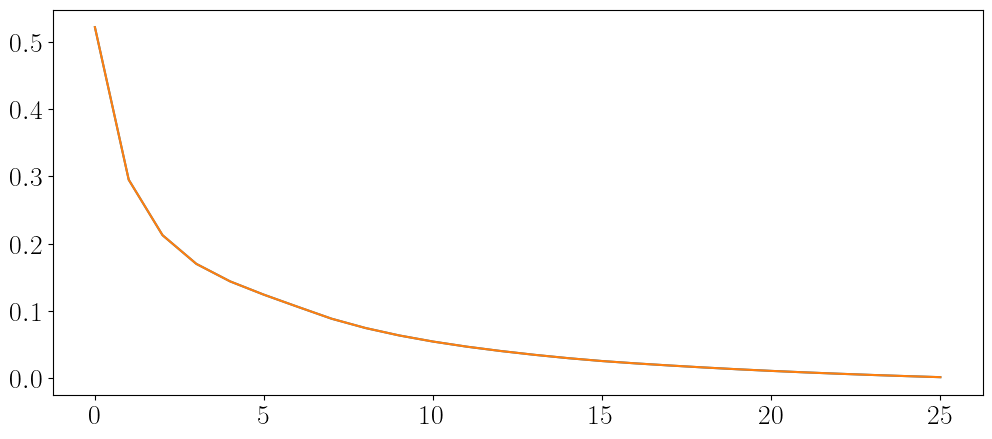

In [38]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(sigma[:,0], label='case 1')
ax.plot(sigma2[:,0], label='case 4')

In [26]:
sigma[:,0]

array([0.52226433, 0.29514794, 0.21257072, 0.16986018, 0.14376026,
       0.12394105, 0.10591682, 0.08822723, 0.07440718, 0.0633124 ,
       0.05420892, 0.04660497, 0.04015806, 0.03448137, 0.02947694,
       0.02520928, 0.02170867, 0.01859396, 0.01567598, 0.01299276,
       0.01056342, 0.00835345, 0.00633446, 0.00448273, 0.00277835,
       0.00120431])